In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

import warnings
warnings.filterwarnings('ignore')

/home/nils/projects/python/tsfresh/venv/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Construct the signal

Just for showing how the forecasting works, we invent our own signal here, that we want to forecast later.
It is a mixture of random noise and some sinus graph with a positive and negative slope.

In [3]:
x_up = np.arange(100)*0.1 + np.sin(30*np.pi*np.linspace(0, 1, 100)) + np.random.normal(scale=0.7,size=100)
x_down = np.arange(100, 0, -1)*0.15 + np.sin(30*np.pi*np.linspace(0, 1, 100)) + np.random.normal(scale=0.7,size=100)
x = np.concatenate([x_up, x_down])
x = pd.Series(data=x, index=pd.date_range('1/1/2011', periods=len(x), freq='H'))
x.head()

2011-01-01 00:00:00    0.270096
2011-01-01 01:00:00    1.073392
2011-01-01 02:00:00    0.274406
2011-01-01 03:00:00    1.446233
2011-01-01 04:00:00   -0.035727
Freq: H, dtype: float64

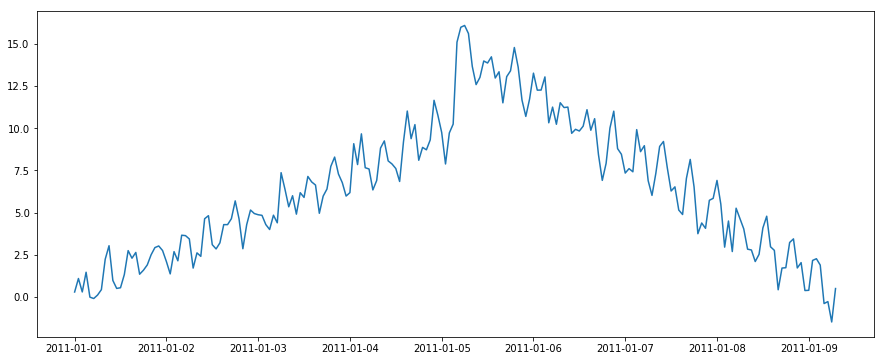

In [4]:
plt.figure(figsize=(15, 6))
plt.plot(x)
plt.show()

So, we have a time series and want to construct a time series model that is able to predict the next data points.

To do that, we have to construct a feature matrix by calculating the features for sub time series (see the forecasting section in the tsfresh documentation).

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
df = pd.DataFrame(x)
df.reset_index(inplace=True)
df.columns = ["time", "value"]
df["kind"] = "a"
df["id"] = 1

In [7]:
df.head()
len(df)

200

In [8]:
from tsfresh.utilities.dataframe_functions import roll_time_series

In [13]:
df_shift, y = make_forecasting_frame(x, kind="price", max_timeshift=10, rolling_direction=1)

`df_shift` is ready to be passed into the feature extraction process in tsfresh 

In [22]:
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, 
                     show_warnings=False)

Feature Extraction: 100%|██████████| 199/199 [00:07<00:00, 27.02it/s]


In [23]:
X.head()

variable,feature__abs_energy,feature__absolute_sum_of_changes,"feature__agg_autocorrelation__f_agg_""mean""","feature__agg_autocorrelation__f_agg_""median""","feature__agg_autocorrelation__f_agg_""var""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","feature__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","feature__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,feature__time_reversal_asymmetry_statistic__lag_1,feature__time_reversal_asymmetry_statistic__lag_2,feature__time_reversal_asymmetry_statistic__lag_3,feature__value_count__value_-inf,feature__value_count__value_0,feature__value_count__value_1,feature__value_count__value_inf,feature__value_count__value_nan,feature__variance,feature__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
2011-01-01 01:00:00,0.072952,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2011-01-01 02:00:00,1.225122,0.803296,-1.000000,-1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.161321,0.0
2011-01-01 03:00:00,1.300420,1.602281,-0.250011,-0.250011,0.562451,0.0,0.0,0.0,0.0,0.0,...,0.002519,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.142631,0.0
2011-01-01 04:00:00,3.392011,2.774108,-0.412896,-0.814122,0.856959,0.0,0.0,0.0,0.0,0.0,...,0.130151,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.261198,0.0
2011-01-01 05:00:00,3.393288,4.256068,-0.095596,-0.107639,0.679607,0.0,0.0,0.0,0.0,0.0,...,0.051083,-0.019668,0.0,0.0,0.0,0.0,0.0,0.0,0.311809,0.0


Here, the first row for `id=2011-01-01 01:00:00` contains features that were just calculate on `2011-01-01 00:00:00`. 
The third row `2011-01-01 03:00:00` contains features that were calculated on `2011-01-01 00:00:00`, `2011-01-01 01:00:00` and `2011-01-01 02:00:00`.

However, because we set `max_timeshift` to 10, the features will only be based on a maximum number of 10 historic data points.

We are now using the features, to train a normal AdaBoostRegressor to predict the next time step. So for every data point, we fit the model on all older data points, then predict the next data point. Then we fit it on all data points again plus that predicted data point and so on.

In [24]:
ada = AdaBoostRegressor()

y_pred = [0] * len(y)
y_pred[0] = y.iloc[0]

for i in range(1, len(y)):
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))
    
y_pred = pd.Series(data=y_pred, index=y.index)

In [25]:
y_pred = pd.Series(data=y_pred, index=y.index)

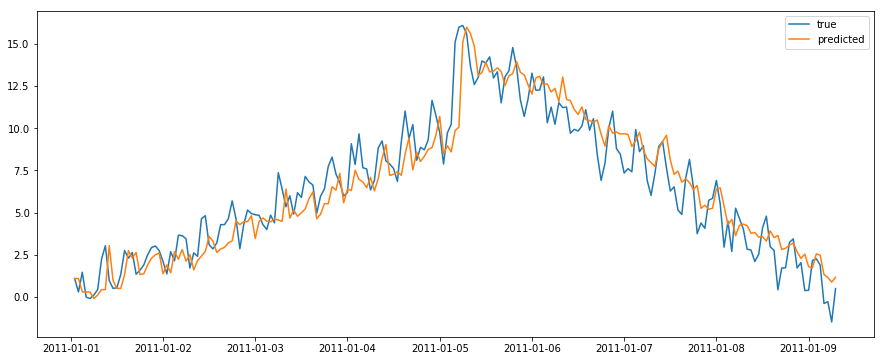

In [26]:
plt.figure(figsize=(15, 6))
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()